In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from datetime import datetime, date
import warnings
warnings.filterwarnings("ignore")
from importlib import reload
import cmocean as cmo

In [2]:
from All_functions import marineHeatWaves 
#package retreived from https://github.com/ecjoliver/marineHeatWaves/blob/master/marineHeatWaves.py
reload(marineHeatWaves)
import All_functions.marineHeatWaves as mhw

In [3]:
from All_functions import Analysis
#My own package :) 
reload(Analysis)
from All_functions.Analysis import *

In [4]:
sst_data = xr.open_mfdataset('SST/*.nc')

In [5]:
#Time series for a particular point: 
point_sst = sst_data.isel(lat=1, lon=1)
sst_array = point_sst.sst.values
time_array = point_sst.time.values
#Convert np.datetime64 to datetime (easier to get year, month, day attribute):
time_array = np.array([pd.to_datetime(x).date() for x in time_array])
ordinal_time_array = np.array([x.toordinal() for x in time_array])

#Use numpy for faster data selecting! 
#Numpy array for selecting data is thousands of times faster than isel and sel of xarray!!!!
sst_values = sst_data.sst.values

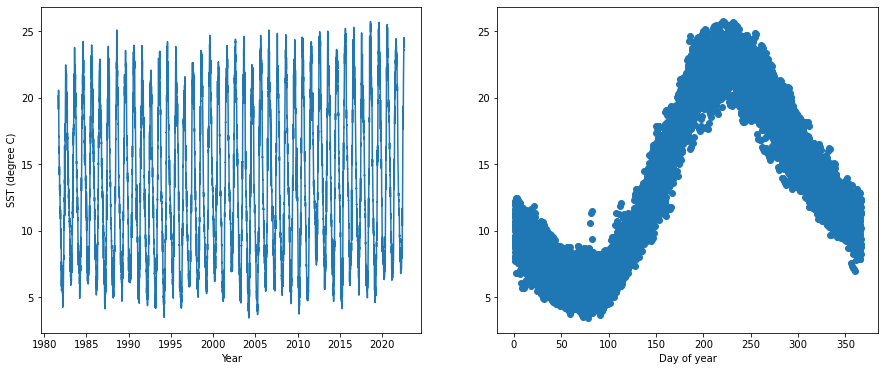

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
axes[0].plot(time_array, sst_array)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('SST (degree C)')
day_of_year_array = [x.timetuple().tm_yday for x in time_array]
decimal_year_array = [x.year+x.month/12+x.day/365.25 for x in time_array]
axes[1].scatter(day_of_year_array, sst_array)
axes[1].set_xlabel('Day of year')
fig.show()

## Develop a threshold for temperature trend:

Criteria for threshold (retreived from Hobday et al., 2015 and implemented by marineHeatWaves package https://github.com/ecjoliver/marineHeatWaves) 

In [5]:
from All_functions import marineHeatWaves 
#package retreived from https://github.com/ecjoliver/marineHeatWaves/blob/master/marineHeatWaves.py
reload(marineHeatWaves)
import All_functions.marineHeatWaves as mhw

In [43]:
from All_functions import Analysis
#My own package :) 
reload(Analysis)
from All_functions.Analysis import *

In [45]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1) #ordinal time
dates = [date.fromordinal(tt.astype(int)) for tt in t] #datetime time
dates2 = [x.year+x.timetuple().tm_yday/365.25 for x in dates]
# Generate synthetic temperature time series
sst = np.zeros(len(t))
sst[0] = 0 # Initial condition
a = 0.85 # autoregressive parameter
for i in range(1,len(t)):
    sst[i] = a*sst[i-1] + 0.75*np.random.randn() + 0.5*np.cos(t[i]*2*np.pi/365.25)
sst = sst - sst.min() + 5.

mhws, clim = mhw.detect(t, sst)
#Index of largest event:
ev = np.argmax(mhws['intensity_max'])

Text(0, 0.5, 'SST [$^\\circ$C]')

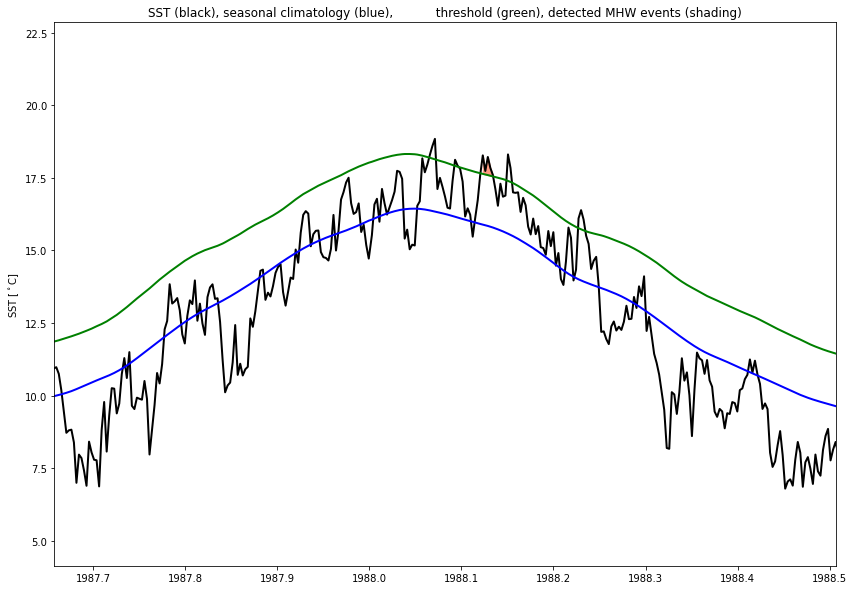

In [46]:
plt.figure(figsize=(14,10))
# Find indices for all ten MHWs before and after event of interest and shade accordingly

for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates2[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
    
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates2[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')

# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates2, sst, 'k-', linewidth=2)
plt.plot(dates2, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates2, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim((mhws['time_start'][ev]-150)/365.25, (mhws['time_end'][ev]+150)/365.25)
#plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [10]:
#Test case for our data: 
mhws, clim = mhw.detect(ordinal_time_array, sst_array)

In [11]:
len(mhws['time_start']), len(mhws['index_start']), len(mhws['time_end']), len(mhws['index_end'])

(76, 76, 76, 76)

In [15]:
binary_heatwave = return_binary_results_of_heatwave(mhws, size=len(ordinal_time_array))
days_of_heatwave = return_days_of_heatwave(mhws)

(735000.0, 738000.0)

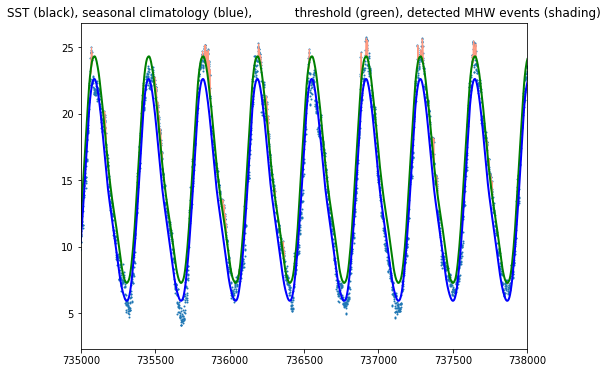

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(ordinal_time_array, sst_array, s=1)
#plt.scatter(days_of_heatwave, [30]*len(days_of_heatwave), s=10)
plt.plot(ordinal_time_array, clim['thresh'], 'g-', linewidth=2)
plt.plot(ordinal_time_array, clim['seas'], 'b-', linewidth=2)

for time_start, time_end in zip(mhws['time_start'], mhws['time_end']):
    t1 = np.where(np.array(ordinal_time_array)==time_start)[0][0]
    t2 = np.where(np.array(ordinal_time_array)==time_end)[0][0]
    plt.fill_between(ordinal_time_array[t1:t2+1], sst_array[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
    
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(735000, 738000)

## Detection for all points:

In [7]:
heatwave_2D_time = np.zeros((14945,28,60))
for ilon in range(len(sst_data.lon.values)):
    for ilat in range(len(sst_data.lat.values)):
        print(ilon, ilat, end='\r')
        #sst_array = sst_data.sst.isel(lat=ilat, lon=ilon).values
        sst_array = sst_values[:,ilat,ilon]
        mhws, clim = mhw.detect(ordinal_time_array, sst_array, climatologyPeriod=[1981,2011])
        binary_heatwave = return_binary_results_of_heatwave(mhws, size=len(ordinal_time_array))
        heatwave_2D_time[:,ilat,ilon] = binary_heatwave
        #np.savetxt(f'extreme_sst_results/{ilon:02}_{ilat:02}.csv', binary_heatwave, delimiter=',')

In [8]:
sst_data['heatwave'] = (('time', 'lat', 'lon'), heatwave_2D_time)

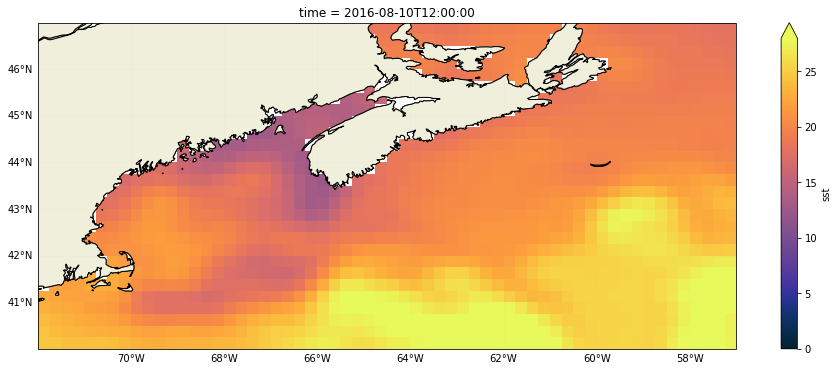

In [26]:
fig, ax = plt.subplots(figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})
im = sst_data.sst.sel(time='2016-08-10').plot(x='lon', y='lat', cmap=cmo.cm.thermal, ax=ax, vmin=0, vmax=28)
background_layer(ax)
fig.show()

In [9]:
monthly_ds = sst_data.resample(time='M').mean()
yearly_ds = sst_data.resample(time='Y').mean()

In [15]:
yearly_ds.sel(time='2000').heatwave.quantile(0.025)

<xarray.DataArray 'heatwave' ()>
array(0.)
Coordinates:
    quantile  float64 0.025

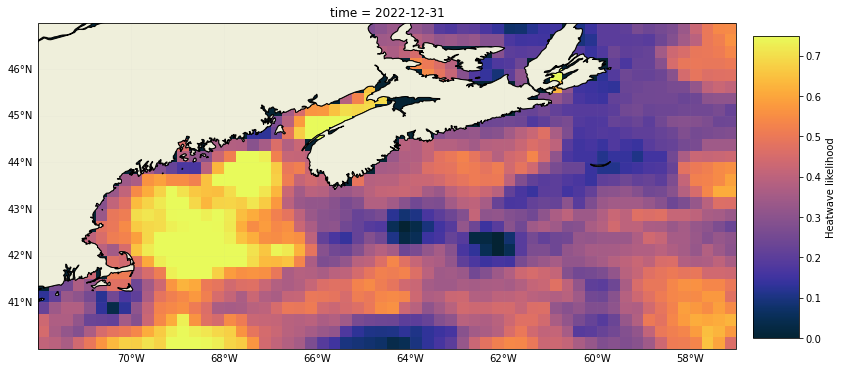

In [24]:
make_animations(yearly_ds, time_frames=yearly_ds.time.values, video_name='yearly_average')

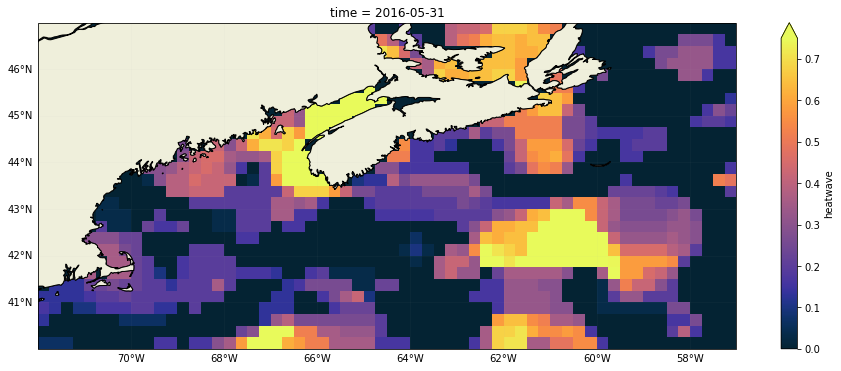

In [23]:
fig, ax = plt.subplots(figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})
monthly_ds.heatwave.sel(time='2016-05').plot(x='lon', y='lat', cmap=cmo.cm.thermal, ax=ax, vmin=0, vmax=0.75)
background_layer(ax)
fig.show()

In [17]:
from All_functions import Analysis
#My own package :) 
reload(Analysis)
from All_functions.Analysis import *